In [19]:
import numpy as np
import pandas as pd

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style='white', palette=None)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])


from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the data

In [3]:
audio_files = glob('./Data/cats_dogs/*.wav')

In [4]:
type(audio_files)

list

In [5]:
first = audio_files[0]
first.split('/')[-1][:3]

'cat'

In [6]:
labels = []
for file in audio_files:
    labels.append(file.split('/')[-1][:3])

In [7]:
labels = np.array(labels)

In [178]:
# Play audio file
ipd.Audio(audio_files[2])

In [9]:
first_audio = librosa.load(audio_files[0])

In [10]:
first_audio[0].shape, first_audio[1]

((136710,), 22050)

In [11]:
y, sr = librosa.load(audio_files[0])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sampling rate (sr): {sr}')

y: [-0.0070141  -0.00710633 -0.00502527 -0.00301624 -0.00223774 -0.00376536
 -0.00595051 -0.00875689 -0.00951335 -0.00496659]
shape y: (136710,)
sampling rate (sr): 22050


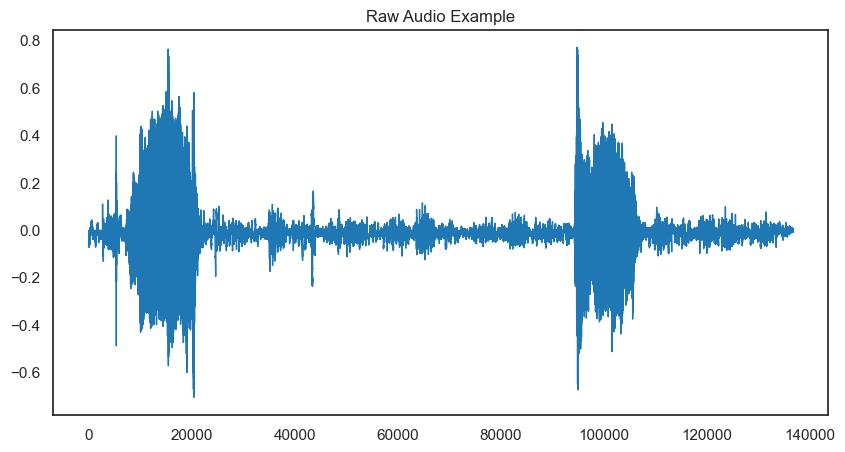

In [12]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                  color=color_pal[0])
plt.show()

<Axes: title={'center': 'Trimmed Audio Sample'}>

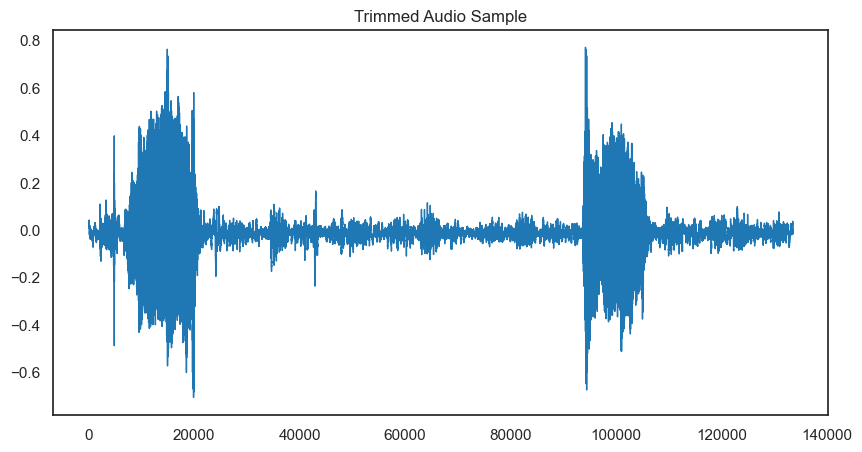

In [20]:
# Trimming leading/lagging silence
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                          lw=1,
                          title='Trimmed Audio Sample',
                          color=color_pal[0])

<Axes: title={'center': 'Sampling Audio'}>

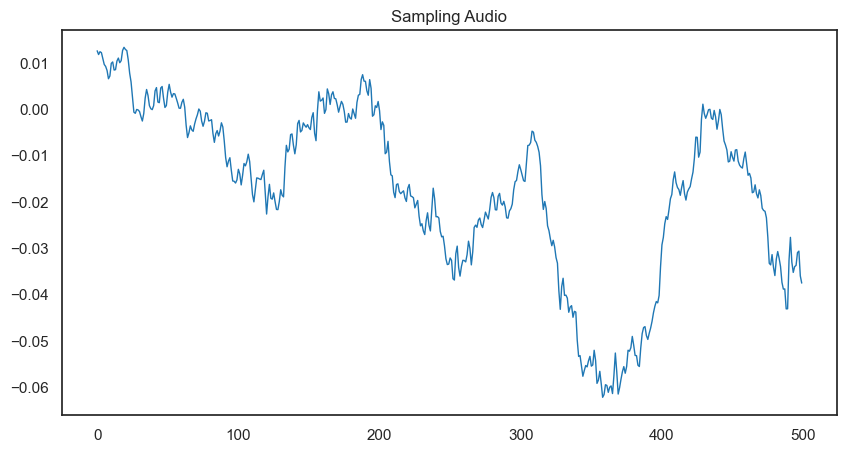

In [21]:
pd.Series(y[30000:30500]).plot(figsize=(10, 5),
                                lw=1,
                                title='Sampling Audio',
                                color=color_pal[0])

# Spectrogram

In [22]:
# Forier Transformation of the Audio data
D = librosa.stft(y) # short Forier transformation
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max) # Take the maximum value as the amplitude
S_db.shape

(1025, 268)

In [23]:
D.shape, y.shape

((1025, 268), (136710,))

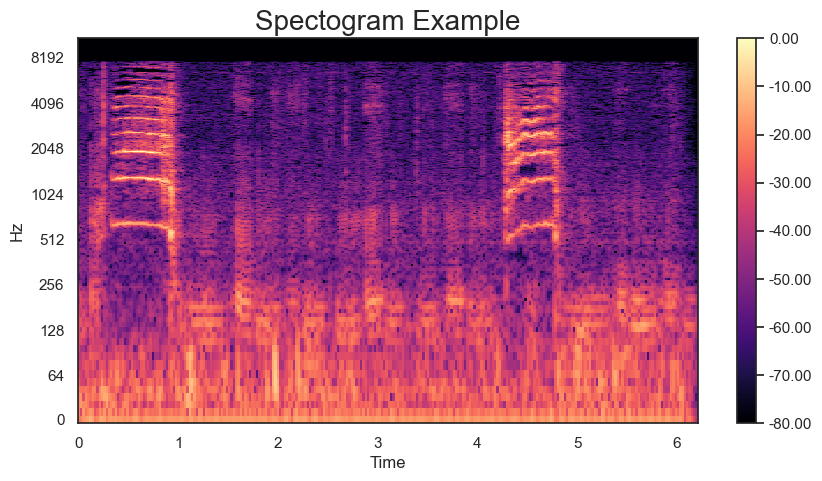

In [24]:
# Plot the Spectogram

fig, ax = plt.subplots(figsize=(10, 5))

img = librosa.display.specshow(S_db, # data to draw spectogram
                               x_axis='time', # x-axis label
                               y_axis='log', # y-axis label
                               ax=ax)

ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%.2f')
plt.show()

# Mel Spectogram

In [25]:
S = librosa.feature.melspectrogram(y=y, # data to convert to melspectrogram data
                                   sr=sr,
                                   n_mels=128 * 2)
S_db_mel = librosa.amplitude_to_db(S, # Data to get the amplitudes
                                   ref=np.max)

In [26]:
S.shape, S_db_mel.shape

((256, 268), (256, 268))

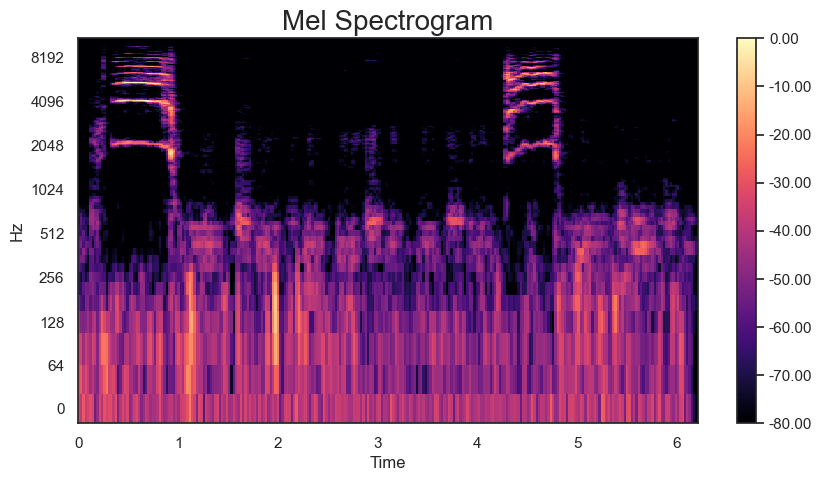

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))

img = librosa.display.specshow(S_db_mel, # Data set to draw mel spectogram
                               x_axis='time',
                               y_axis='log',
                               ax=ax)

ax.set_title('Mel Spectrogram', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%.2f')


# Classification

In [28]:
from sklearn.linear_model import LogisticRegression

In [45]:
min_len = min(df.audio.map(lambda x: len(x)))
min_len

20360

In [34]:
# Build the whole training set
# y, sr = librosa.load(audio_files[0])
import librosa
df = pd.DataFrame()
data = []

for audio in audio_files:
    y, _ = librosa.load(audio)
    data.append(y)

data = pd.Series(data)
df['audio'] = data

In [36]:
df['label'] = pd.Series(labels)

In [56]:
df.head()

,audio,label
0,"[-0.007014099, -0.00710633, -0.005025272, -0.0...",cat
1,"[-8.748088e-07, -1.9708292e-05, -5.435923e-05,...",dog
2,"[1.3186603e-11, -1.9145078e-11, -4.9883726e-12...",cat
3,"[-1.9376983e-05, -3.2515894e-05, -0.0001455399...",dog
4,"[-0.3553277, -0.21875851, 0.08652463, 0.254573...",cat


In [49]:
# normalize the shape of each audio data
df['audio'] = df.audio.map(lambda x: x[:min_len])

In [62]:
df["audio"][0]

X = np.vstack(df['audio'].to_numpy())

In [150]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df['label'].values, test_size=0.2, random_state=42)

In [67]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [69]:
y_pred = lr.predict(X_test)
    

In [70]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         cat       0.72      0.95      0.82        38
         dog       0.67      0.22      0.33        18

    accuracy                           0.71        56
   macro avg       0.69      0.58      0.58        56
weighted avg       0.70      0.71      0.66        56



In [123]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

gamma = {'gamma': np.arange(0.003, 0.005, 0.0001)}

svc = SVC(kernel='rbf')
grid_search = GridSearchCV(estimator=svc, param_grid=gamma, cv=5)

grid_search.fit(X_train, y_train)
# svc.fit(X_train, y_train)
best_gamma = grid_search.best_params_['gamma']
best_gamma

0.0037999999999999987

In [124]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', gamma=0.0038)
svc.fit(X_train, y_train)

SVC(gamma=0.0038)

In [125]:
y_pred = svc.predict(X_test)

In [126]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         cat       0.88      0.76      0.82        38
         dog       0.61      0.78      0.68        18

    accuracy                           0.77        56
   macro avg       0.74      0.77      0.75        56
weighted avg       0.79      0.77      0.77        56



## CNN model

In [131]:
from tensorflow.keras.layers import MaxPooling1D, Conv1D
import keras
from tensorflow.keras import layers

In [133]:
X_train[0].shape

(20360,)

In [ ]:
# model_cat = keras.Sequential([
#     layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(20360,)),    
#     layers.MaxPooling1D(2),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(1, activation='sigmoid')])

In [151]:
y_train = (y_train=='cat')*1
y_test = (y_test=='cat')*1
y_train

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1])

In [153]:
import tensorflow as tf
from tensorflow.keras import layers
n = min_len
# Define the CNN model
model = tf.keras.Sequential([
    layers.Reshape((n, 1), input_shape=(n,)),  # Reshape input to (n, 1) for 1D convolution
    layers.Conv1D(32, 3, activation='relu'),  # Convolutional layer with 32 filters and kernel size 3
    layers.MaxPooling1D(2),                   # Max pooling layer with pool size 2
    layers.Conv1D(64, 3, activation='relu'),  # Convolutional layer with 64 filters and kernel size 3
    layers.MaxPooling1D(2),                   # Max pooling layer with pool size 2
    layers.Flatten(),                         # Flatten the output for dense layers
    layers.Dense(128, activation='relu'),     # Dense layer with 128 units and ReLU activation
    layers.Dense(1, activation='sigmoid')  # Output layer with softmax activation
])
 
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
 
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)
 
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/10


2023-06-21 15:36:25.907523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 2s 168ms/step - loss: 2.6900 - accuracy: 0.5701
Epoch 2/10
7/7 [==============================] - 1s 137ms/step - loss: 0.9235 - accuracy: 0.7919
Epoch 3/10
7/7 [==============================] - 1s 136ms/step - loss: 0.4951 - accuracy: 0.8326
Epoch 4/10
7/7 [==============================] - 1s 136ms/step - loss: 0.4027 - accuracy: 0.8552
Epoch 5/10
7/7 [==============================] - 1s 136ms/step - loss: 0.3866 - accuracy: 0.8552
Epoch 6/10
7/7 [==============================] - 1s 137ms/step - loss: 0.3702 - accuracy: 0.8643
Epoch 7/10
7/7 [==============================] - 1s 136ms/step - loss: 0.3530 - accuracy: 0.8462
Epoch 8/10
7/7 [==============================] - 1s 144ms/step - loss: 0.3176 - accuracy: 0.8778
Epoch 9/10
7/7 [==============================] - 1s 144ms/step - loss: 0.2879 - accuracy: 0.8824
Epoch 10/10
1/2 [==============>...............] - ETA: 0s - loss: 0.7100 - accuracy: 0.8750

2023-06-21 15:36:36.359562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 154ms/step - loss: 0.7579 - accuracy: 0.8393
Test loss: 0.7578964233398438
Test accuracy: 0.8392857313156128


In [156]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_hat = (y_pred>0.5)*1

print(classification_report(y_test, y_hat))

2/2 [==============================] - 0s 105ms/step
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        18
           1       0.87      0.89      0.88        38

    accuracy                           0.84        56
   macro avg       0.82      0.81      0.81        56
weighted avg       0.84      0.84      0.84        56



In [176]:
model_v2 = tf.keras.Sequential([
    layers.Reshape((n, 1), input_shape=(n,)),  # Reshape input to (n, 1) for 1D convolution
    layers.Conv1D(32, 3, activation='leaky_relu'),  # Convolutional layer with 32 filters and kernel size 3
    layers.MaxPooling1D(2),                   # Max pooling layer with pool size 2
    layers.Conv1D(64, 3, activation='leaky_relu'),  # Convolutional layer with 64 filters and kernel size 3
    layers.MaxPooling1D(2),                   # Max pooling layer with pool size 2
    layers.Flatten(),                         # Flatten the output for dense layers
    layers.Dense(128, activation='leaky_relu'),     # Dense layer with 128 units and ReLU activation
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Output layer with softmax activation
])

In [177]:
import tensorflow as tf
model_v2.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
hitstory = model_v2.fit(X_train, y_train, epochs=10, batch_size=32)
 
# Evaluate the model
test_loss, test_acc = model_v2.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

from sklearn.metrics import classification_report
y_pred = model_v2.predict(X_test)
y_hat = (y_pred>0.5)*1

print(classification_report(y_test, y_hat))

Epoch 1/10


2023-06-21 15:49:48.050572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 2s 238ms/step - loss: 1.6685 - accuracy: 0.6244
Epoch 2/10
7/7 [==============================] - 1s 155ms/step - loss: 0.7581 - accuracy: 0.7557
Epoch 3/10
7/7 [==============================] - 1s 140ms/step - loss: 0.2707 - accuracy: 0.9005
Epoch 4/10
7/7 [==============================] - 1s 142ms/step - loss: 0.2065 - accuracy: 0.9321
Epoch 5/10
7/7 [==============================] - 1s 139ms/step - loss: 0.1410 - accuracy: 0.9548
Epoch 6/10
7/7 [==============================] - 1s 139ms/step - loss: 0.1308 - accuracy: 0.9502
Epoch 7/10
7/7 [==============================] - 1s 139ms/step - loss: 0.1055 - accuracy: 0.9593
Epoch 8/10
7/7 [==============================] - 1s 139ms/step - loss: 0.0811 - accuracy: 0.9638
Epoch 9/10
7/7 [==============================] - 1s 139ms/step - loss: 0.0708 - accuracy: 0.9774
Epoch 10/10
1/2 [==============>...............] - ETA: 0s - loss: 0.4656 - accuracy: 0.9062

2023-06-21 15:49:59.344861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 82ms/step - loss: 0.5506 - accuracy: 0.8571
Test loss: 0.5506016612052917
Test accuracy: 0.8571428656578064
2/2 [==============================] - 0s 70ms/step
              precision    recall  f1-score   support

           0       0.81      0.72      0.76        18
           1       0.88      0.92      0.90        38

    accuracy                           0.86        56
   macro avg       0.84      0.82      0.83        56
weighted avg       0.85      0.86      0.85        56



2023-06-21 15:49:59.621557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


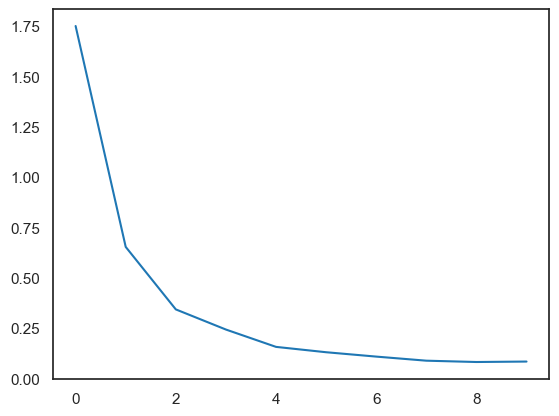

In [171]:
loss = hitstory.history['loss']

plt.plot(loss)

# With Our Own Voice

In [4]:
audio_lin = glob('./Data/data/Lin.mp3')
audio_Maria = glob('./Data/data/Maria.mp3')
audio_Martin = glob('./Data/data/Martin.mp3')

In [5]:
print(audio_lin)

ipd.Audio(audio_lin[0])

['./Data/data/Lin.mp3']


In [6]:
lin_audio, sr = librosa.load('./Data/data/Lin.mp3')
maria_audio, _ = librosa.load('./Data/data/Maria.mp3')
martin_audio, _ = librosa.load('./Data/data/Martin.mp3')

In [7]:
lin_audio, maria_audio, martin_audio

(array([ 1.1913607e-04,  2.1239312e-04,  5.3814736e-05, ...,
        -1.2042282e-02, -1.2785713e-02, -1.1612723e-02], dtype=float32),
 array([4.0597370e-05, 6.2262530e-05, 3.8573191e-05, ..., 1.6253921e-01,
        1.8173030e-01, 0.0000000e+00], dtype=float32),
 array([-7.9118778e-05, -1.6879068e-04, -2.4141265e-04, ...,
         9.9774916e-03,  1.0704011e-02,  1.0906715e-02], dtype=float32))

In [10]:
lin_audio.shape, maria_audio.shape, martin_audio.shape

((1323206,), (1323206,), (1323206,))

In [9]:
maria_audio= maria_audio[:lin_audio.shape[0]]

In [11]:
partitions = maria_audio.shape[0]//(sr*3)

slice_audio = sr*3
    
def slice_audio(audio, partitions=partitions,slice_audio=slice_audio):
    my_list = [None]*partitions

    for i in range(partitions):
        my_list[i] = audio[i*slice_audio:(i+1)*slice_audio]
    
    return np.array(my_list)    


In [12]:
maria_audio_sliced = slice_audio(maria_audio)
lin_audio_sliced = slice_audio(lin_audio)
martin_audio_sliced = slice_audio(martin_audio)

In [13]:
maria_audio_sliced.shape, lin_audio_sliced.shape, martin_audio_sliced.shape

((20, 66150), (20, 66150), (20, 66150))

In [23]:
labels = [0]*20 + [1]*20 + [2]*20


In [24]:
X = np.vstack((maria_audio_sliced, martin_audio_sliced, lin_audio_sliced))
X.shape

(60, 66150)

In [25]:
labels = np.array(labels)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42,stratify=labels)

In [27]:
X_train.shape, y_train.shape

((48, 66150), (48,))

In [28]:
import tensorflow as tf
from tensorflow.keras import layers
n = 66150
# Define the CNN model
model = tf.keras.Sequential([
    layers.Reshape((n, 1), input_shape=(n,)),  # Reshape input to (n, 1) for 1D convolution
    layers.Conv1D(16, 3, activation='relu'),  # Convolutional layer with 32 filters and kernel size 3
    layers.MaxPooling1D(2),                   # Max pooling layer with pool size 2
    layers.Conv1D(32, 3, activation='relu'),  # Convolutional layer with 64 filters and kernel size 3
    layers.MaxPooling1D(2),                   # Max pooling layer with pool size 2
    layers.Flatten(),  
    layers.Dropout(0.5),                     # Dropout layer with 0.5 dropout rate# Flatten the output for dense layers
    layers.Dense(64, activation='relu'),     # Dense layer with 128 units and ReLU activation
    layers.Dense(3, activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.0002),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/10
3/3 [==============================] - 4s 812ms/step - loss: 1.2575 - accuracy: 0.2500
Epoch 2/10
3/3 [==============================] - 2s 800ms/step - loss: 0.8765 - accuracy: 0.4792
Epoch 3/10
3/3 [==============================] - 2s 812ms/step - loss: 0.7313 - accuracy: 0.8750
Epoch 4/10
3/3 [==============================] - 2s 814ms/step - loss: 0.5514 - accuracy: 0.8542
Epoch 5/10
3/3 [==============================] - 2s 772ms/step - loss: 0.4554 - accuracy: 0.8958
Epoch 6/10
3/3 [==============================] - 3s 861ms/step - loss: 0.3349 - accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 2s 715ms/step - loss: 0.2370 - accuracy: 1.0000
Epoch 8/10
3/3 [==============================] - 2s 727ms/step - loss: 0.1568 - accuracy: 1.0000
Epoch 9/10
3/3 [==============================] - 2s 736ms/step - loss: 0.0964 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 413ms/step - loss: 1.0060 - accuracy: 0.6667
Test loss: 1.005952

In [21]:
y_pre = model.predict(X_test)

y_hat = np.argmax(y_pre, axis=1)

print(y_hat,'\n', y_test)
print(classification_report(y_test, y_hat))

1/1 [==============================] - 0s 18ms/step
[0 1 1 1 2 1 0 0 2 1 2 0] 
 [0 2 1 1 2 0 2 0 1 1 2 0]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.60      0.75      0.67         4
           2       0.67      0.50      0.57         4

    accuracy                           0.67        12
   macro avg       0.67      0.67      0.66        12
weighted avg       0.67      0.67      0.66        12



## XGBoost Classification

In [128]:
from xgboost import XGBClassifier

In [173]:
from xgboost import XGBClassifier

params = {'objective': 'multi:softmax',
          'num_class': 3,
          'max_depth': 6,
          'eval_metric': 'merror'}

xgb = XGBClassifier(n_estimators=1000, 
                    learning_rate=0.45,
                    # max_depth=6,
                    # min_child_weight=1, 
                    # gamma=0.0, 
                    # subsample=0.8, 
                    # colsample_bytree=0.8, 
                    objective='multi:softmax',
                    nthread=10,
                    seed=27)

In [174]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.45, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, nthread=10,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [175]:
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb

array([2, 2, 2, 1, 2, 0, 1, 0, 2, 0, 1, 2], dtype=int32)

In [176]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.33      0.25      0.29         4
           2       0.33      0.50      0.40         4

    accuracy                           0.42        12
   macro avg       0.44      0.42      0.42        12
weighted avg       0.44      0.42      0.42        12



### RandomForestClassifier

In [210]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, criterion='log_loss' , max_depth=4, min_samples_split=.2, min_samples_leaf=2)

In [211]:
rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=4, min_samples_leaf=2,
                       min_samples_split=0.2, n_estimators=500)

In [212]:
y_pred_rfc = rfc.predict(X_test)
y_pred_rfc

array([1, 2, 1, 1, 2, 1, 2, 0, 2, 1, 1, 0])

In [213]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.50      0.75      0.60         4
           2       0.75      0.75      0.75         4

    accuracy                           0.67        12
   macro avg       0.75      0.67      0.67        12
weighted avg       0.75      0.67      0.67        12

